# Investigate Bering-Chukchi surface flux-wind-transport anomaly feedback
Danielson et al. 2020 propose a feedback loop for Arctic amplification where the elevated ocean temperatures in the summer and fall lead to an enhanced ocean to atmosphere heat flux that strengthens the northward winds through Bering Strait. The change in wind strength increases Bering Strait volume transports through stronger, northward geostrophic currents in Bering Strait.

This notebook compares the linear trends for the Sep-Dec anomalies for:
1. SST
2. Surface heat fluxes (missing)
3. Meridional Winds

in OM4!

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Set model paths

In [3]:
base = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'
pp = base + 'OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'

In [4]:
# output
dir_surf = pp + 'ocean_monthly/ts/monthly/20yr/'
dir_BS = pp + 'ocean_Bering_Strait/ts/monthly/20yr/'

## Get file lists

In [5]:
# SST
flist_sst = glob(f'{dir_surf}*tos.nc')
# Wind stress
flist_v10 = glob(f'{dir_surf}*tauvo.nc')
# Transports
flist_T = glob(f'{dir_BS}*vo.nc')

## Read in model data

In [6]:
def open_model_data(flist):
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=['average_DT', 'average_T1', 'average_T2']
                          ).sel(time=slice('1979',None))
    return DS

In [7]:
# SST
DS_sst = open_model_data(flist_sst)

In [8]:
# Wind
DS_v10 = open_model_data(flist_v10)

In [9]:
# Transports
DS_T = open_model_data(flist_T
                      ).rename_dims({'xh_sub01':'xh','yq_sub01':'yq'}
                                   ).rename({'xh_sub01':'xh','yq_sub01':'yq'}
                                           ).squeeze()

## Open Ocean Static

In [10]:
OceStat = xr.open_dataset(pp + 'ocean_monthly/ocean_monthly.static.nc',engine='netcdf4')

## Assign geolat, geolon, and dy to outputs

In [11]:
# SST
DS_sst = DS_sst.assign_coords({'lon':OceStat['geolon'].sel(xh=DS_sst.xh,yh=DS_sst.yh),
                               'lat':OceStat['geolat'].sel(xh=DS_sst.xh,yh=DS_sst.yh)})

In [12]:
# Wind stress
DS_v10 = DS_v10.assign_coords({'lon':OceStat['geolon_v'].sel(xh=DS_v10.xh,yq=DS_v10.yq),
                               'lat':OceStat['geolat_v'].sel(xh=DS_v10.xh,yq=DS_v10.yq)})

In [13]:
# Transport
DS_T = DS_T.assign_coords({'lon':OceStat['geolon_v'].sel(xh=DS_T.xh,yq=DS_T.yq),
                           'lat':OceStat['geolat_v'].sel(xh=DS_T.xh,yq=DS_T.yq)})
# add dy
DS_T['dyCv'] = OceStat['dyCv'].sel(xh=DS_T.xh,yq=DS_T.yq)

## Maps of analysis region

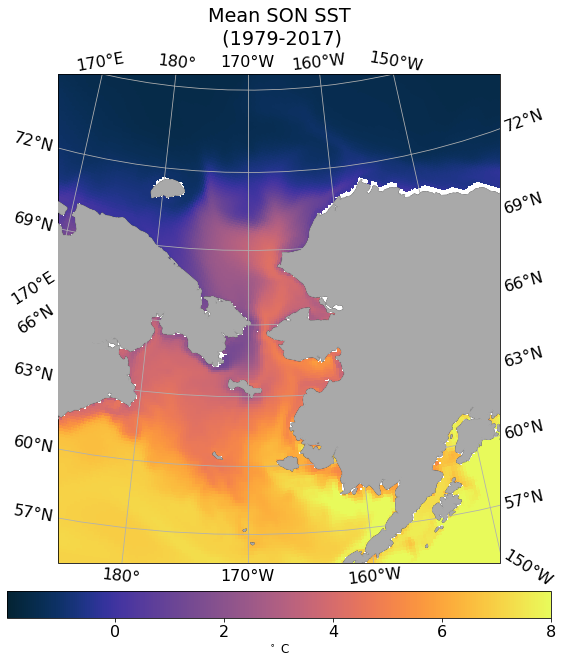

In [14]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_sst['lon']
Y = DS_sst['lat']
Z = DS_sst['tos'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.thermal',vmax=8)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON SST\n ({DS_sst.time.dt.year.values[0]}-{DS_sst.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ$ C',fontsize=12)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

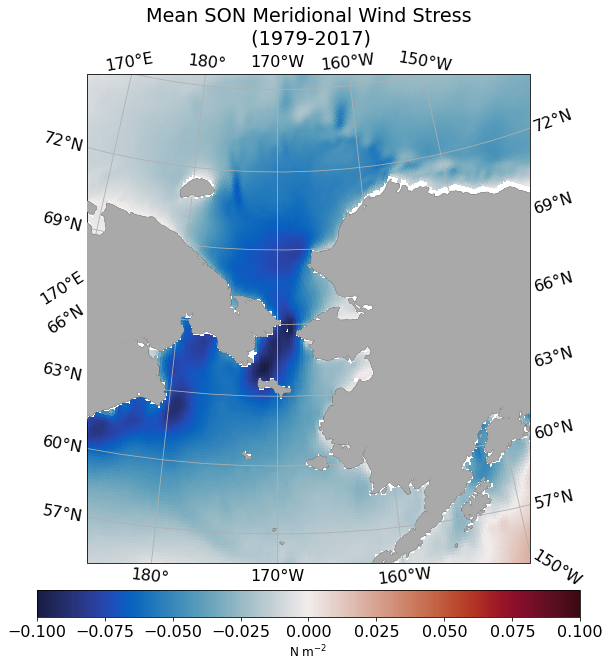

In [15]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_v10['lon']
Y = DS_v10['lat']
Z = DS_v10['tauvo'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.balance',vmin=-0.1, vmax=0.1)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON Meridional Wind Stress\n ({DS_v10.time.dt.year.values[0]}-{DS_v10.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('N m$^{-2}$',fontsize=12)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

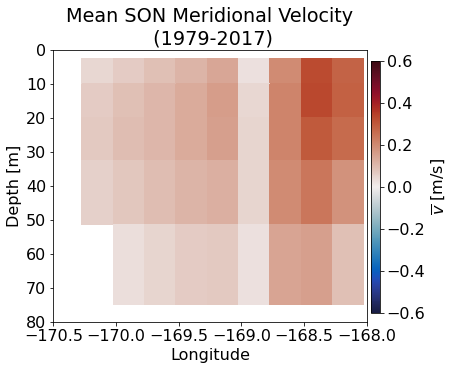

In [16]:
# Cross-sections of mean meridional velocity
vlim = 0.6
fig,ax = plt.subplots(figsize=(6,5))

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_T['lon']
Y = DS_T['z_l']
Z = DS_T['vo'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,cmap='cmo.balance',vmin=-vlim, vmax=vlim)

ax.set_ylim(0,80)
ax.set_xlim(-170.5,-168)
ax.invert_yaxis()
ax.set_title(f'Mean SON Meridional Velocity\n ({DS_T.time.dt.year.values[0]}-{DS_T.time.dt.year.values[-1]})')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Longitude')

# additional formatting
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\overline{v}$ [m/s]')
plt.show()

## Set lat,lon for analysis

In [17]:
lats = np.array([50, 80])
lons = np.array([-200, -130])

## Extract regions for analysis

In [18]:
# SST
sst = DS_sst.sel(xh=slice(lons[0],lons[1]),yh=slice(lats[0],lats[1])).drop(['time_bnds'])

In [19]:
# Winds
v10 = DS_v10.sel(xh=slice(lons[0],lons[1]),yq=slice(lats[0],lats[1])).drop(['time_bnds'])

In [20]:
# Transport
T = DS_T.drop(['time_bnds','dyCv'])

## Calulate linear regressions on seasonal anomalies
Following the method for calculating standard error as is given on pages 250-254 of Thomson and Emery and use the seasons as defined in Danielson et al. 2020

In [21]:
def linReg_Sclim(ds):
    def mk_lr(ds,mons,season_str):
        # make seasonal timeseries
        Sds = ds.sel(time=ds.time.dt.month.isin(mons)).groupby('time.year').mean()
        # calc linear regression for chosen months
        lr = Sds.polyfit('year',1,full=True).assign_coords(season=season_str).expand_dims('season')
        # rename coefficients
        lr = lr.rename({[s for s in list(lr.keys()) if "coefficients" in s][0]:'b0_b1'})
        # rename sum of squared errors
        lr = lr.rename({[s for s in list(lr.keys()) if "residuals" in s][0]:'SSE'})
        # add sample size
        lr['N'] = (('season'),[len(Sds.year)])
        # calculate the standard error of the estimate
        lr['s_err'] = (lr['SSE']/(lr['N']-2))**(1/2)
        # calc spread in time
        dt = (Sds.year - Sds.year.mean()).values
        # calculate the standard error of the slope (dea)
        lr['s_b1'] = lr['s_err']/((dt**2).sum()**(1/2))
        # calc mask for statistical significance
        lr['b1_mask'] = (abs(lr['b0_b1'].sel(degree=1)) < (2*lr['s_b1'])).astype(int)
        return lr
    
    # lists of months and seasons
    imons = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
    seas = ['JFM','AMJ','JAS','OND']
    # get linear regression coefficients for winter and initialize dataset
    LR = mk_lr(ds,imons[0],seas[0])
    for i in range(1,4):
        # calc lin regress for next month
        _LR = mk_lr(ds,imons[i],seas[i])
        # concat with previous months
        LR = xr.concat([LR, _LR],"season")
    return LR

In [22]:
# SST
LRs_sst = linReg_Sclim(sst).load()

In [23]:
# winds
LRs_v10 = linReg_Sclim(v10).load()

In [24]:
# Transports
LRs_T = linReg_Sclim(T).load()

## Calulate linear regressions on monthly anomalies
Following the method for calculating standard error as is given on pages 250-254 of Thomson and Emery

In [25]:
def linReg_Mclim(ds):
    def mk_lr(ds,mon):
        # get linear regression coefficients for Jan and initialize dataset
        lr = ds.isel(time=ds.groupby('time.month').groups[mon]).polyfit(
            'time',1,full=True).assign_coords(month=mon).expand_dims('month')
        # rename coefficients
        lr = lr.rename({[s for s in list(lr.keys()) if "coefficients" in s][0]:'b0_b1'})
        # rename sum of squared errors
        lr = lr.rename({[s for s in list(lr.keys()) if "residuals" in s][0]:'SSE'})
        # add sample size
        lr['N'] = (('month'),[len(ds.isel(time=ds.groupby('time.month').groups[mon]).time)])
        # calculate the standard error of the estimate
        lr['s_err'] = (lr['SSE']/(lr['N']-2))**(1/2)
        # calc spread in time
        dt = (ds.isel(time=ds.groupby('time.month').groups[mon]).time - 
              ds.isel(time=ds.groupby('time.month').groups[mon]).time.mean()).astype(float).values
        # calculate the standard error of the slope (dea)
        lr['s_b1'] = lr['s_err']/((dt**2).sum()**(1/2))
        # calc mask for statistical significance
        lr['b1_mask'] = (abs(lr['b0_b1'].sel(degree=1)) < (2*lr['s_b1'])).astype(int)
        return lr
    # get linear regression coefficients for Jan and initialize dataset
    LR = mk_lr(ds,1)
    for i in range(2,13):
        # calc lin regress for next month
        _LR = mk_lr(ds,i)
        # concat with previous months
        LR = xr.concat([LR, _LR],"month")
    return LR

In [26]:
# SST
LRm_sst = linReg_Mclim(sst).load()

In [27]:
# winds
LRm_v10 = linReg_Mclim(v10).load()

In [28]:
# Transports
LRm_T = linReg_Mclim(T).load()

## Plot maps of linear regressions

In [29]:
LRs_T = LRs_T.assign_coords(yq=T.yq)
LRm_T = LRm_T.assign_coords(yq=T.yq)

In [30]:
# Add lat, lon coords again
LRs_sst = LRs_sst.assign_coords({'lon':sst['lon'].sel(xh=LRs_sst.xh,yh=LRs_sst.yh),
                                 'lat':sst['lat'].sel(xh=LRs_sst.xh,yh=LRs_sst.yh)})
LRm_sst = LRm_sst.assign_coords({'lon':sst['lon'].sel(xh=LRm_sst.xh,yh=LRm_sst.yh),
                                 'lat':sst['lat'].sel(xh=LRm_sst.xh,yh=LRm_sst.yh)})

In [31]:
# Add lat, lon coords again
LRs_v10 = LRs_v10.assign_coords({'lon':v10['lon'].sel(xh=LRs_v10.xh,yq=LRs_v10.yq),
                                 'lat':v10['lat'].sel(xh=LRs_v10.xh,yq=LRs_v10.yq)})
LRm_v10 = LRm_v10.assign_coords({'lon':v10['lon'].sel(xh=LRm_v10.xh,yq=LRm_v10.yq),
                                 'lat':v10['lat'].sel(xh=LRm_v10.xh,yq=LRm_v10.yq)})

In [32]:
# Add lat, lon coords again
LRs_T = LRs_T.assign_coords({'lon':T['lon'].sel(xh=LRs_T.xh),
                             'lat':T['lat'].sel(xh=LRs_T.xh)})
LRm_T = LRm_T.assign_coords({'lon':T['lon'].sel(xh=LRm_T.xh),
                             'lat':T['lat'].sel(xh=LRm_T.xh)})

In [33]:
def bering_section(ds,ax,vMM,inNS):
    # convert units of the trend from ns to years
    if inNS:
        t_con = 1e9 * 86400 * 365.25
    else:
        t_con = 1
    
    # Pull variables for plotting
    x = ds['lon']
    y = ds['z_l']
    z = t_con*ds['b0_b1'].sel(degree=1)
    mask = ds['b1_mask']
    
    # plot trend
    im = ax.pcolormesh(x,y,z,cmap='cmo.balance',vmin=-vMM,vmax=vMM)
    # add mask
    n_levels = 1
    ax.contourf(x,y,mask,n_levels,colors='none',hatches=[None,'xxx'])
    # Zoom in around the Bering Strait
    ax.set_ylim(0,80)
    ax.set_xlim(-170.5,-168)
    ax.invert_yaxis()
    return im

In [34]:
def bering_map(ds,ax,vMM,inNS):
    # convert units of the trend from ns to years
    if inNS:
        t_con = 1e9 * 86400 * 365.25
    else:
        t_con = 1
    
    # Specify data projection
    crs = ccrs.PlateCarree()
    
    # Pull variables for plotting
    x = ds['lon']
    y = ds['lat']
    z = t_con*ds['b0_b1'].sel(degree=1)
    mask = ds['b1_mask']
    
    # plot trend
    im = ax.pcolormesh(x,y,z,transform=crs,cmap='cmo.balance',
                      vmin=-vMM,vmax=vMM)
    # add mask
    n_levels = 1
    ax.contourf(x,y,mask,n_levels,colors='none',hatches=[None,'xxx'],
                transform=crs)
    # Zoom in around the Bering Strait
    ax.set_extent([175, 210, 55, 75], crs=crs)
    
    # Add a land mask to your plot, as well as grid lines and coastlines
    ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
    gl = ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
                      crs=crs,xlocs=[180,-170,-160,-150])
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.coastlines()
    return im

### Seasonal regressions

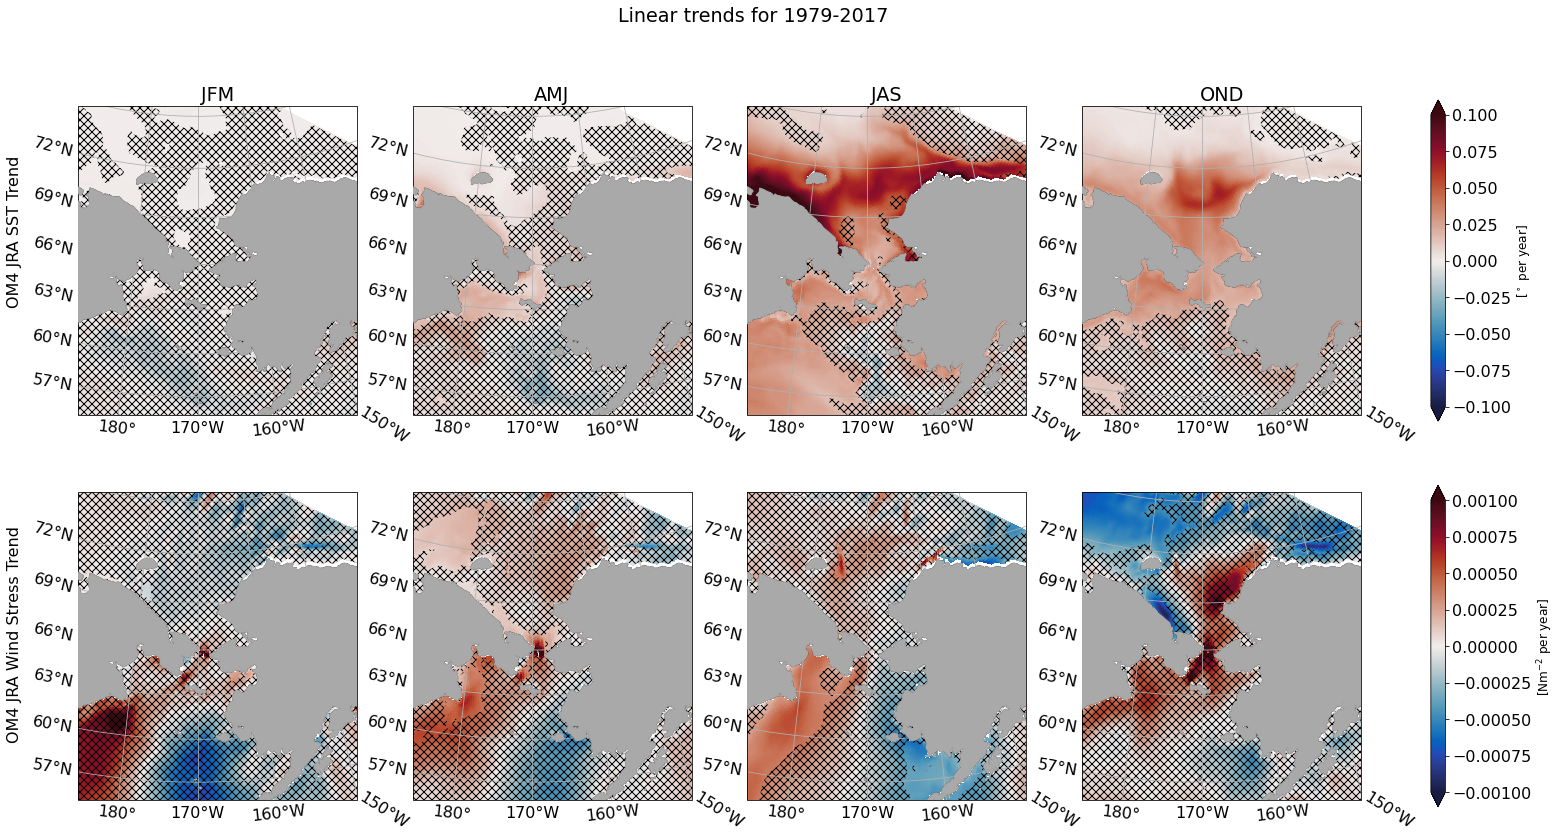

In [35]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(25,13),nrows=2,ncols=4,
                      subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})
# step through seasons
for i in range(0,4):
    # sst
    im_sst  = bering_map(LRs_sst.isel(season=i),ax[0,i],0.1,False)
    # v10
    im_v10 = bering_map(LRs_v10.isel(season=i),ax[1,i],1e-3,False)

# Add colorbars
# sst trend
cbar_sst = plt.colorbar(im_sst,ax=ax[0,:],fraction=0.03,pad=0.05,extend='both')
cbar_sst.set_label('[$^\circ$ per year]',fontsize=12)
# v10 trend
cbar_v10 = plt.colorbar(im_v10,ax=ax[1,:],fraction=0.03,pad=0.05,extend='both')
cbar_v10.set_label('[Nm$^{-2}$ per year]',fontsize=12)

# Additional formatting
fig.suptitle('Linear trends for 1979-2017')
ax[0,0].set_title('JFM')
ax[0,1].set_title('AMJ')
ax[0,2].set_title('JAS')
ax[0,3].set_title('OND')

fig.text(0.09, 0.74,'OM4 JRA SST Trend',
             ha='center', va='center', rotation='vertical')
fig.text(0.09, 0.31, 'OM4 JRA Wind Stress Trend',
             ha='center', va='center', rotation='vertical')
plt.show()

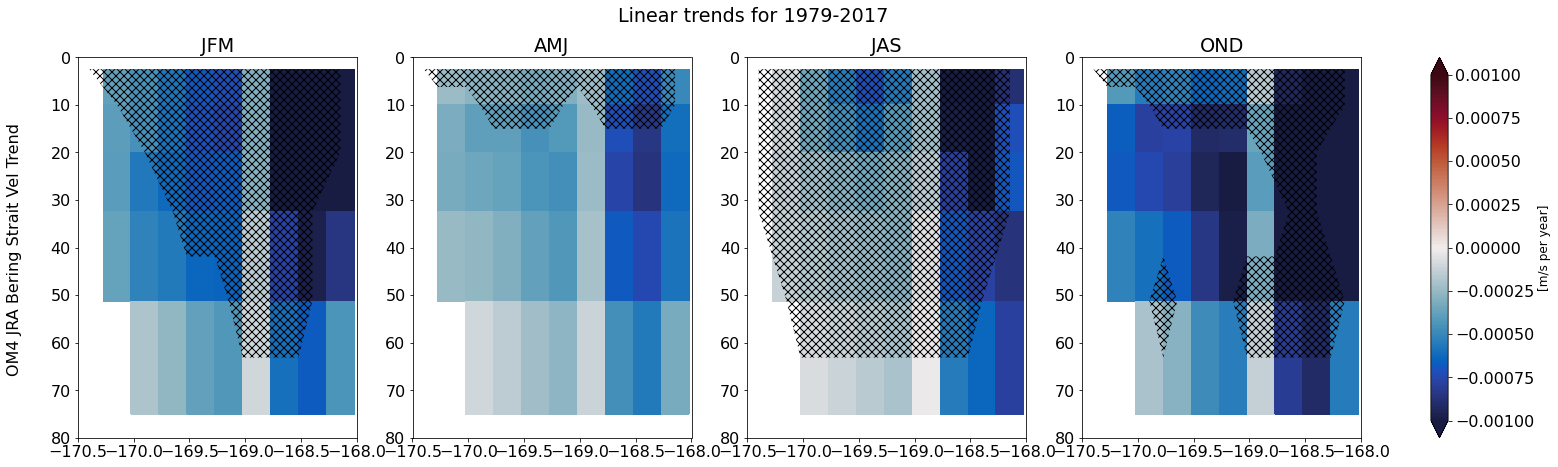

In [36]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(25,7),nrows=1,ncols=4)
# step through seasons
for i in range(0,4):
    # transport
    im_T = bering_section(LRs_T.isel(season=i),ax[i],1e-3,False)

# Add colorbar
# T trend
cbar_T = plt.colorbar(im_T,ax=ax,fraction=0.03,pad=0.05,extend='both')
cbar_T.set_label('[m/s per year]',fontsize=12)

# Additional formatting
fig.suptitle('Linear trends for 1979-2017')
ax[0].set_title('JFM')
ax[1].set_title('AMJ')
ax[2].set_title('JAS')
ax[3].set_title('OND')

fig.text(0.09, 0.5, 'OM4 JRA Bering Strait Vel Trend',
         ha='center', va='center', rotation='vertical')
plt.show()

### Monthly regressions

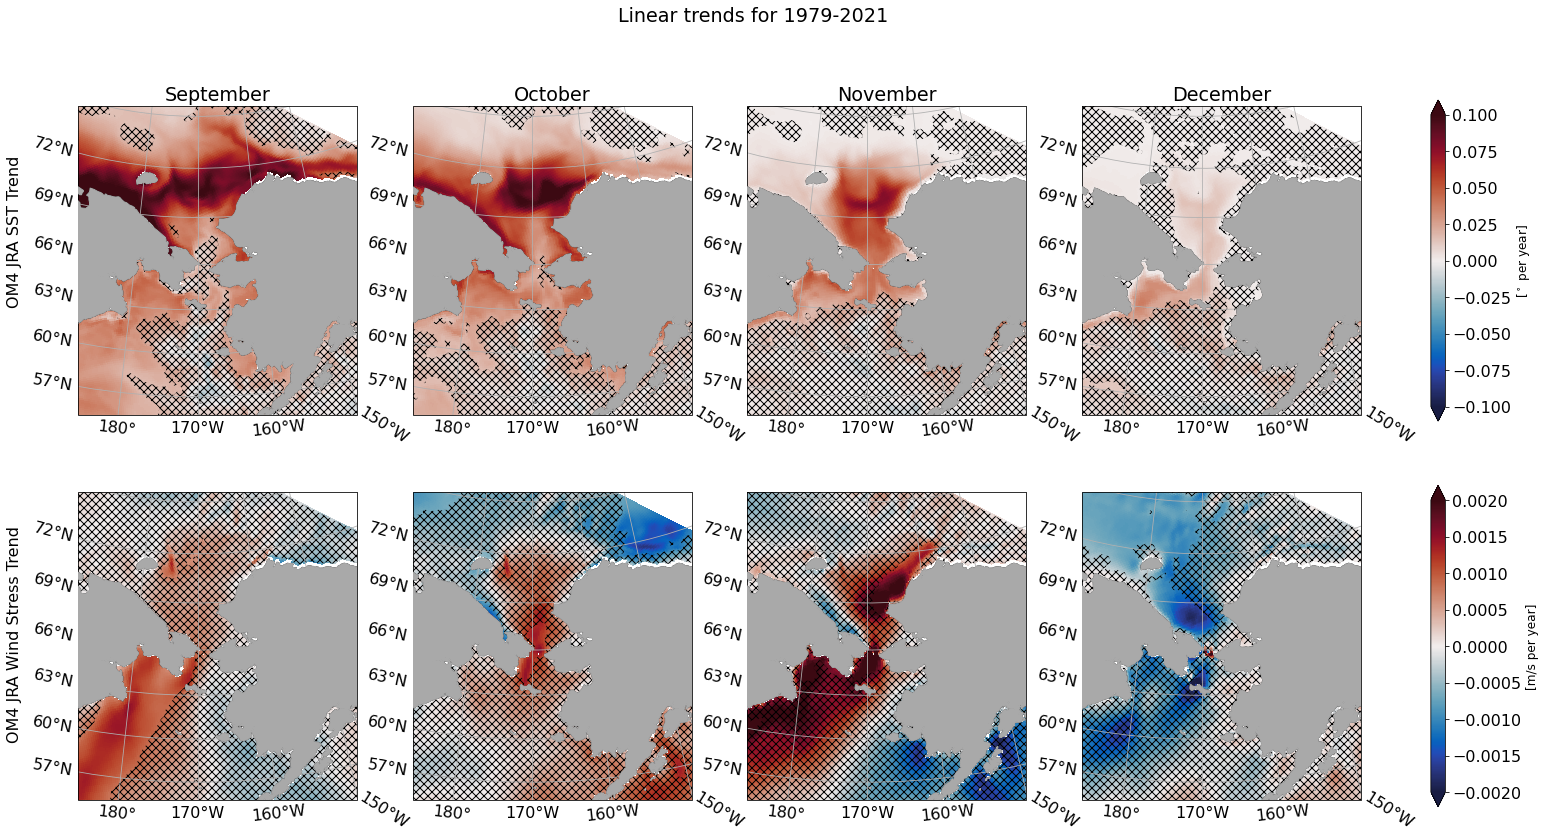

In [37]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(25,13),nrows=2,ncols=4,
                      subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})
# step through months
for (mon,col) in zip([9,10,11,12],[0,1,2,3]):
    # sst
    im_sst  = bering_map(LRm_sst.sel(month=mon),ax[0,col],0.1,True)
    # v10
    im_v10 = bering_map(LRm_v10.sel(month=mon),ax[1,col],2e-3,True)

# Add colorbars
# sst trend
cbar_sst = plt.colorbar(im_sst,ax=ax[0,:],fraction=0.03,pad=0.05,extend='both')
cbar_sst.set_label('[$^\circ$ per year]',fontsize=12)
# v10 trend
cbar_v10 = plt.colorbar(im_v10,ax=ax[1,:],fraction=0.03,pad=0.05,extend='both')
cbar_v10.set_label('[m/s per year]',fontsize=12)

# Additional formatting
fig.suptitle('Linear trends for 1979-2021')
ax[0,0].set_title('September')
ax[0,1].set_title('October')
ax[0,2].set_title('November')
ax[0,3].set_title('December')

fig.text(0.09, 0.74,'OM4 JRA SST Trend',
             ha='center', va='center', rotation='vertical')
fig.text(0.09, 0.31, 'OM4 JRA Wind Stress Trend',
             ha='center', va='center', rotation='vertical')
plt.show()

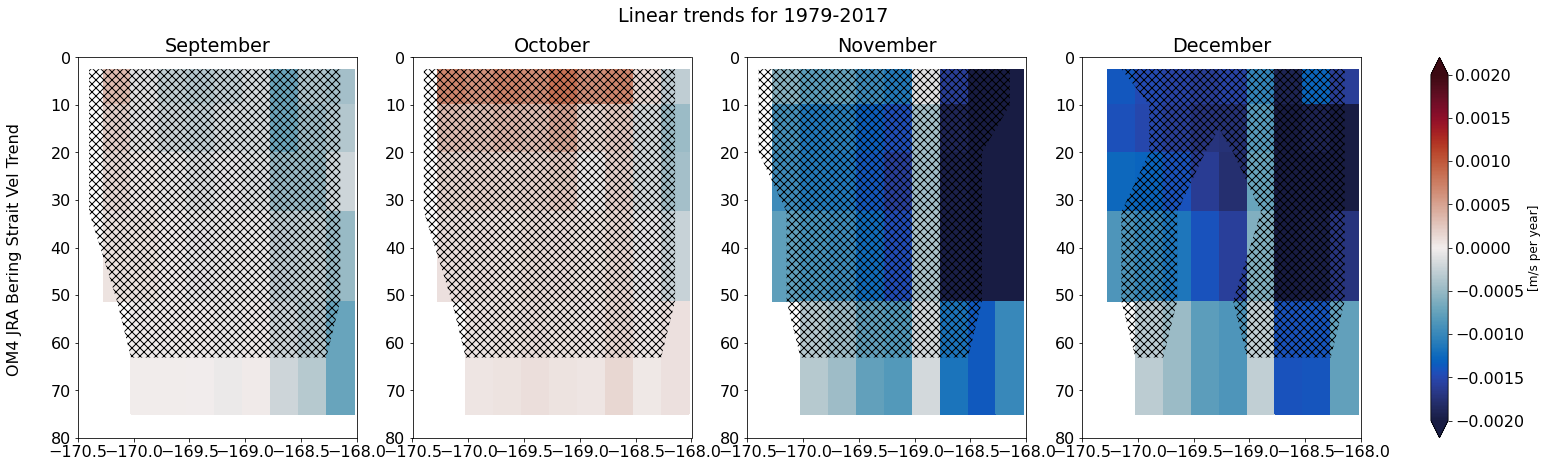

In [38]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(25,7),nrows=1,ncols=4)

# step through months
for (mon,col) in zip([9,10,11,12],[0,1,2,3]):
    # transport
    im_T = bering_section(LRm_T.sel(month=mon),ax[col],2e-3,True)

# Add colorbar
# T trend
cbar_T = plt.colorbar(im_T,ax=ax,fraction=0.03,pad=0.05,extend='both')
cbar_T.set_label('[m/s per year]',fontsize=12)

# Additional formatting
fig.suptitle('Linear trends for 1979-2017')
ax[0].set_title('September')
ax[1].set_title('October')
ax[2].set_title('November')
ax[3].set_title('December')

fig.text(0.09, 0.5, 'OM4 JRA Bering Strait Vel Trend',
         ha='center', va='center', rotation='vertical')
plt.show()